### Data Import

Note, for this first section, I used solution code, the rest is my own work

In [119]:
import sqlite3
conn = sqlite3.connect('/Users/michaelshea/desktop/DSI-DC-1/week-05/1.3-database_lab_1/assets/datasets/enron.db') 
c = conn.cursor()
c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()

[(u'MessageBase',), (u'RecipientBase',), (u'EmployeeBase',)]

In [120]:
# Print the first 5 rows of EmployeeBase table

results = c.execute("SELECT * FROM EmployeeBase LIMIT 5;").fetchall()
for row in results:
    print row

(1, u'John Arnold', u'Forestry', u'ENA Gas Financial', u'VP Trading', u'Male', u'Senior')
(2, u'Harry Arora', u'Forestry', u'ENA East Power', u'VP Trading', u'Male', u'Senior')
(3, u'Robert Badeer', u'Forestry', u'ENA West Power', u'Mgr Trading', u'Male', u'Junior')
(4, u'Susan Bailey', u'Legal', u'ENA Legal', u'Specialist Legal', u'Female', u'Junior')
(5, u'Eric Bass', u'Forestry', u'ENA Gas Texas', u'Trader', u'Male', u'Junior')


In [73]:
# Print the first 5 rows of MessageBase table

results = c.execute("SELECT * FROM MessageBase LIMIT 5;").fetchall()
for row in results:
    print row

(1, u'taylor-m/sent/11', 910930020, u'Cd$ CME letter', 138)
(2, u'taylor-m/sent/17', 911459940, u'Indemnification', 138)
(3, u'taylor-m/sent/18', 911463840, u'Re: Indemnification', 138)
(4, u'taylor-m/sent/23', 911874180, u'Re: Coral Energy, L.P.', 138)
(5, u'taylor-m/sent/27', 912396120, u'Bankruptcy Code revisions', 138)


In [74]:
# Print the first 5 rows in RecipientBase table

# The first field is message id, the second is recipient number, and the third is the id of the recipient.
# mid, rno, to_eid

results = c.execute("SELECT * FROM RecipientBase LIMIT 5;").fetchall()
for row in results:
    print row

(1, 1, 59)
(2, 1, 15)
(3, 1, 15)
(4, 1, 109)
(4, 2, 49)


In [75]:
# Import each of the three tables to a pandas DataFrame

import pandas as pd
from pandas.io import sql

employees = pd.read_sql("SELECT * FROM EmployeeBase;", conn)

In [76]:
employees.head()

,eid,name,department,longdepartment,title,gender,seniority
0,1,John Arnold,Forestry,ENA Gas Financial,VP Trading,Male,Senior
1,2,Harry Arora,Forestry,ENA East Power,VP Trading,Male,Senior
2,3,Robert Badeer,Forestry,ENA West Power,Mgr Trading,Male,Junior
3,4,Susan Bailey,Legal,ENA Legal,Specialist Legal,Female,Junior
4,5,Eric Bass,Forestry,ENA Gas Texas,Trader,Male,Junior


In [77]:
messages = pd.read_sql('SELECT * FROM MessageBase;', conn)

In [78]:
messages.head()

,mid,filename,unix_time,subject,from_eid
0,1,taylor-m/sent/11,910930020,Cd$ CME letter,138
1,2,taylor-m/sent/17,911459940,Indemnification,138
2,3,taylor-m/sent/18,911463840,Re: Indemnification,138
3,4,taylor-m/sent/23,911874180,"Re: Coral Energy, L.P.",138
4,5,taylor-m/sent/27,912396120,Bankruptcy Code revisions,138


In [79]:
recipients = pd.read_sql("SELECT * FROM RecipientBase;", conn)

In [80]:
recipients.head()

,mid,rno,to_eid
0,1,1,59
1,2,1,15
2,3,1,15
3,4,1,109
4,4,2,49


### Data Exploration

In [17]:
# How many employees are there in the company?


print "There are %r employees in the company." % len(employees.index)

There are 156 employees in the company.


In [18]:
# How many messages are there in the database?

print "There are %r messages in the database." % len(messages.index)

There are 21635 messages in the database.


In [19]:
# Convert the timestamp column in the messages. When was the oldest message sent? And the newest?

messages.dtypes

mid           int64
filename     object
unix_time     int64
subject      object
from_eid      int64
dtype: object

In [81]:
# Convert using unit='s'

messages.unix_time = pd.to_datetime(messages.unix_time, unit='s')

# NOTE TO SELF: make sure to specify unit='s' because these appear to be seconds since epoch.

In [83]:
# When was the oldest message sent? 

messages.unix_time.max()

Timestamp('2002-06-21 13:37:34')

In [23]:
# And the newest?

messages.unix_time.min()

Timestamp('1998-11-13 04:07:00')

In [38]:
# Some messages are sent to more than one recipient. 
# Group the messages by message_id and count the number of recepients. 

# Use pandas groupby function:
recipient_count = recipients.groupby(['mid']).count()

(array([  2.11460000e+04,   3.70000000e+02,   1.07000000e+02,
          6.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          4.00000000e+00]),
 array([  1. ,   6.6,  12.2,  17.8,  23.4,  29. ,  34.6,  40.2,  45.8,
         51.4,  57. ]),
 <a list of 10 Patch objects>)

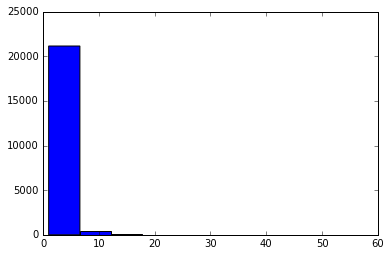

In [41]:
# Then look at the distribution of recepient numbers.

from matplotlib import pyplot as plt
% matplotlib inline

# Plot a histogram of recipient counts
plt.hist(recipient_count.rno, bins = 10)

In [42]:
# Aso look at value_counts
recipient_count.rno.value_counts()

1     14985
2      2962
3      1435
4       873
5       711
6       180
7       176
8        61
13       57
11       47
12       33
10       29
15       28
9        24
14       11
16        9
21        2
17        2
57        2
22        1
52        1
20        1
55        1
19        1
24        1
18        1
49        1
Name: rno, dtype: int64

In [43]:
# How many messages have only one recepient?

# From above value_counts:
print 14985

14985


In [84]:
# Who sent the message with the highest number of recepients?

# Merge on 'mid' between messages and recipients
merged = pd.merge(messages, recipients, on='mid', how='inner')

In [121]:
merged.groupby(['mid']).count().sort_values(by='rno', ascending = False).head()

,filename,unix_time,subject,from_eid,rno,to_eid
mid,,,,,,
12116,57,57,57,57,57,57
12151,57,57,57,57,57,57
12140,55,55,55,55,55,55
14404,52,52,52,52,52,52
16035,49,49,49,49,49,49


In [52]:
# Plot using bokeh

from bokeh.io import output_notebook
from bokeh.charts import Histogram



In [50]:
output_notebook()

Loading BokehJS ...

In [54]:
hist = Histogram(recipient_count.rno, title="Recipient Count")
show(hist)

### Data Merging

In [86]:
# Are there more Men or Women employees?

employees.gender.value_counts()


Male      113
Female     43
Name: gender, dtype: int64

In [87]:
# How is gender distributed across departments?

employees['gender_new'] = employees.gender.map({'Male':0, 'Female':1})
employees.head()

,eid,name,department,longdepartment,title,gender,seniority,gender_new
0,1,John Arnold,Forestry,ENA Gas Financial,VP Trading,Male,Senior,0
1,2,Harry Arora,Forestry,ENA East Power,VP Trading,Male,Senior,0
2,3,Robert Badeer,Forestry,ENA West Power,Mgr Trading,Male,Junior,0
3,4,Susan Bailey,Legal,ENA Legal,Specialist Legal,Female,Junior,1
4,5,Eric Bass,Forestry,ENA Gas Texas,Trader,Male,Junior,0


In [95]:
messages.head(2)

,mid,filename,unix_time,subject,from_eid,eid
0,1,taylor-m/sent/11,1998-11-13 04:07:00,Cd$ CME letter,138,138
1,2,taylor-m/sent/17,1998-11-19 07:19:00,Indemnification,138,138


In [90]:
# Gender distributed across departments

employees.groupby(['gender', 'department']).count()

eid  name  longdepartment  title  seniority  gender_new
gender department                                                         
Female Forestry     10    10              10     10         10          10
       Legal        13    13              13     13         13          13
       Other        20    20              20     20         20          20
Male   Forestry     50    50              50     50         50          50
       Legal        12    12              12     12         12          12
       Other        51    51              51     51         51          51

In [96]:
# Who is sending more emails? Men or Women?

# First, to enable join, you need to create a common column header
messages['eid'] = messages['from_eid']
messages.head()

# Then merge the two on 'eid' or employee ID
mess_emp = pd.merge(messages, employees, on='eid', how='inner')

# Finally groupby gender
mess_emp.groupby(['gender']).count()

# From below: if you look at counts of message IDs, men are sending about 1.5x emails as women

,mid,filename,unix_time,subject,from_eid,eid,name,department,longdepartment,title,seniority,gender_new
gender,,,,,,,,,,,,
Female,8794,8794,8794,8794,8794,8794,8794,8794,8794,8794,8794,8794
Male,12841,12841,12841,12841,12841,12841,12841,12841,12841,12841,12841,12841


In [110]:
# What's the average number of emails sent by each gender?

# First get counts of men and women
gender_counts = employees.gender.value_counts()
print gender_counts

# Then extract total number of emails sent by each gender
women_sends = float(8794)
men_sends = float(12841)

# Next, divide # of messages sent by gender counts
print "Average emails sent by women:"
print round(8794. / 43., 1)
print "Average emails sent by men:"
print round(12841 / 113, 1)

Male      113
Female     43
Name: gender, dtype: int64
Average emails sent by women:
204.5
Average emails sent by men:
113.0


In [111]:
# Are there more Juniors or Seniors?

employees.groupby(['seniority']).count()

# From below, we see more juniors

,eid,name,department,longdepartment,title,gender,gender_new
seniority,,,,,,,
Junior,82,82,82,82,82,82,82
Senior,74,74,74,74,74,74,74


In [112]:
# Who is sending more emails? Juniors or Seniors?

# To do this, use the above merged table of messages and employees, and this time group by seniority:
mess_emp.groupby(['seniority']).count()

# From below, looks like seniors are sending many more emails

,mid,filename,unix_time,subject,from_eid,eid,name,department,longdepartment,title,gender,gender_new
seniority,,,,,,,,,,,,
Junior,9196,9196,9196,9196,9196,9196,9196,9196,9196,9196,9196,9196
Senior,12439,12439,12439,12439,12439,12439,12439,12439,12439,12439,12439,12439


In [113]:
# Which department is sending more emails? How does that relate with the number of employees in the department?

# Again, return to the merged table, just groupby department
mess_emp.groupby(['department']).count()

# As would make sense, the legal department is sending the most emails.

,mid,filename,unix_time,subject,from_eid,eid,name,longdepartment,title,gender,seniority,gender_new
department,,,,,,,,,,,,
Forestry,4387,4387,4387,4387,4387,4387,4387,4387,4387,4387,4387,4387
Legal,10396,10396,10396,10396,10396,10396,10396,10396,10396,10396,10396,10396
Other,6852,6852,6852,6852,6852,6852,6852,6852,6852,6852,6852,6852


In [118]:
# Who are the top 3 senders of emails? (people who sent out the most emails)

mess_emp.groupby(['from_eid']).count().sort_values(by='mid', ascending=False).head(3)

# So, from the below table, you can see employee number 20 sent the most emails, 1,597

,mid,filename,unix_time,subject,eid,name,department,longdepartment,title,gender,seniority,gender_new
from_eid,,,,,,,,,,,,
20,1597,1597,1597,1597,1597,1597,1597,1597,1597,1597,1597,1597
59,1379,1379,1379,1379,1379,1379,1379,1379,1379,1379,1379,1379
120,1142,1142,1142,1142,1142,1142,1142,1142,1142,1142,1142,1142


In [ ]:
Also answer the following questions regarding received messages
Who is receiving more emails? Men or Women?
Who is receiving more emails? Juniors or Seniors?
Which department is receiving more emails? How does that relate with the number of employees in the department?
Who are the top 5 receivers of emails? (people who received the most emails)